# Comparing Forecasts on Major League Baseball (MLB) Games

We compare probability forecasts on the outcome of all MLB games from 2010 to 2019, culminating with the [2019 World Series](https://en.wikipedia.org/wiki/2019_World_Series) between Houston Astros and Washington Nationals. 

The 2019 World Series was a challenging forecasting problem, as the underdog Nationals defied the odds given by many professional forecasters and baseball experts and won 4-3.
It was also [the only major championship series in the four North American sports where the visiting team won all games](https://www.cbssports.com/mlb/news/nationals-vs-astros-road-team-wins-all-seven-games-of-2019-world-series-to-make-history-and-defy-odds/). 
We compare various forecasters that made forecasts game-by-game and compare their performances.


YJ Choe [yjchoe@cmu.edu]

In [1]:
import itertools
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import comparecast as cc

%matplotlib inline

In [2]:
# significance level
ALPHA = 0.05

# optimized intrinsic time
V_OPT = 100

## Data

We use three sets of forecasts on the outcome of MLB games from 2010 to 2019, leading up to the final seven World Series games. 
The three forecasts are:
- FiveThirtyEight's win probability projection using the new method (`fivethirtyeight`);
- Closing odds converted to probabilities (source: [Vegas-Odds.com](Vegas-Odds.com)) (`vegas`);
- Various simple baselines from our synthetic experiments (`random`, `laplace`, `k29`).

We make use of [FiveThirtyEight's MLB records](https://github.com/fivethirtyeight/data/tree/6f5b4898481a71cd85ea3c03bb1613dd4a43275b/mlb-elo) as well as its predictions.
The event of interest is defined as whether the Nationals win each game.  
For forecasting algorithms, we use all Nationals games (regular season & postseason) from 2010 to 2019.

## Retrieve FiveThirtyEight Data + Precompute Baselines

In [3]:
team = "MLB"
start_year, end_year = 2010, 2019
plots_dir = f"./plots/{team.lower()}_{start_year}_{end_year}"
os.makedirs(plots_dir, exist_ok=True)

save_file = "data/mlb_elo_538_with_baselines.csv"
data = cc.data_utils.baseball.preprocess_mlb_baselines(2010, 2019, save_file=save_file)  # all years, all teams
data

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,constant_log5_prob1,constant_log5_prob2,laplace_prob1,laplace_prob2,laplace_log5_prob1,laplace_log5_prob2,k29_prob1,k29_prob2,k29_log5_prob1,k29_log5_prob2
0,2010-04-04,2010,0,NaN,BOS,NYY,1537.262000,1568.875000,0.489046,0.510954,...,0.5,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
12,2010-04-05,2010,0,NaN,ARI,SDP,1484.224000,1482.275000,0.537274,0.462726,...,0.5,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
11,2010-04-05,2010,0,NaN,ATL,CHC,1519.750000,1505.513000,0.554806,0.445194,...,0.5,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
10,2010-04-05,2010,0,NaN,CHW,CLE,1507.788000,1480.701000,0.572995,0.427005,...,0.5,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
9,2010-04-05,2010,0,NaN,CIN,STL,1492.738000,1515.010000,0.502487,0.497513,...,0.5,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24648,2019-10-25,2019,0,w,WSN,HOU,1593.827376,1590.078806,0.553044,0.446956,...,0.5,0.5,0.475988,0.524012,0.437416,0.562584,0.508571,0.491429,0.527073,0.472927
24649,2019-10-26,2019,0,w,WSN,HOU,1589.985555,1593.920627,0.538425,0.461575,...,0.5,0.5,0.473813,0.526187,0.431914,0.568086,0.516476,0.483524,0.551632,0.448368
24650,2019-10-27,2019,0,w,WSN,HOU,1584.005206,1599.900976,0.515546,0.484454,...,0.5,0.5,0.471658,0.528342,0.426493,0.573507,0.507236,0.492764,0.522241,0.477759
24651,2019-10-29,2019,0,w,HOU,WSN,1605.069000,1578.837182,0.595209,0.404791,...,0.5,0.5,0.530477,0.469523,0.578848,0.421152,0.501092,0.498908,0.503315,0.496685


In [4]:
# home win probability
data["win"] = (data["score1"] >= data["score2"]).astype(int)
data["y"] = data["win"]
data["time"] = data.groupby(["date", "team1", "team2"]).ngroup(ascending=True) + 1
data.sort_values("time", inplace=True)

forecasters = [f + "_prob1" for f in ["rating", "elo", "constant", "laplace", "k29"]]
data = data[["date", "season", "playoff", "team1", "team2", 
             "score1", "score2", "time", "y", "win"] + forecasters].copy()
data.rename(lambda x: {
    "rating_prob1": "fivethirtyeight",
    "elo_prob1": "fivethirtyeight_old",
    "constant_prob1": "constant",
    "laplace_prob1": "laplace",
    "k29_prob1": "k29",
}.get(x, x), axis=1, inplace=True)
data.tail(14)

,date,season,playoff,team1,team2,score1,score2,time,y,win,fivethirtyeight,fivethirtyeight_old,constant,laplace,k29
24639,2019-10-13,2019,l,HOU,NYY,3.0,2.0,24377,1,1,0.572595,0.539407,0.5,0.503955,0.520325
24640,2019-10-14,2019,l,WSN,STL,8.0,1.0,24378,1,1,0.548193,0.597434,0.5,0.511365,0.530884
24642,2019-10-15,2019,l,NYY,HOU,1.0,4.0,24379,0,0,0.487959,0.545260,0.5,0.493778,0.487732
24641,2019-10-15,2019,l,WSN,STL,7.0,4.0,24380,1,1,0.630898,0.612518,0.5,0.513871,0.538824
24643,2019-10-17,2019,l,NYY,HOU,3.0,8.0,24381,0,0,0.567884,0.531325,0.5,0.491531,0.480209
24644,2019-10-18,2019,l,NYY,HOU,4.0,1.0,24382,1,1,0.491436,0.513249,0.5,0.489304,0.471826
24645,2019-10-19,2019,l,HOU,NYY,6.0,4.0,24383,1,1,0.543097,0.566291,0.5,0.508401,0.536715
24646,2019-10-22,2019,w,HOU,WSN,4.0,5.0,24384,0,0,0.620572,0.576279,0.5,0.528860,0.500000
24647,2019-10-23,2019,w,HOU,WSN,3.0,12.0,24385,0,0,0.590066,0.566903,0.5,0.526425,0.499644
24648,2019-10-25,2019,w,WSN,HOU,1.0,4.0,24386,0,0,0.526852,0.553044,0.5,0.475988,0.508571


## Process Vegas Odds & Combine with the FiveThirtyEight Data

Source: https://sports-statistics.com/sports-data/mlb-historical-odds-scores-datasets/

In [5]:
vegas_odds = cc.data_utils.baseball.read_vegas_odds(start_year, end_year, team)
vegas_odds.tail(7)

,date,team1,pitcher1,final1,open1,close1,team2,pitcher2,final2,open2,...,open_prob1,open_prob2,open_log5_prob1,open_log5_prob2,close_iprob1,close_iprob2,close_prob1,close_prob2,close_log5_prob1,close_log5_prob2
24642,2019-10-22,HOU,GCOLE-R,4,-200,-200.0,WAS,MSCHERZER-R,5,179,...,0.650350,0.349650,0.775765,0.224235,0.666667,0.357143,0.651163,0.348837,0.777007,0.222993
24643,2019-10-23,HOU,JVERLANDER-R,3,-175,-172.0,WAS,SSTRASBURG-R,12,157,...,0.620559,0.379441,0.727870,0.272130,0.632353,0.383142,0.622704,0.377296,0.731468,0.268532
24644,2019-10-25,WAS,ASANCHEZ-R,1,110,140.0,HOU,ZGREINKE-R,4,-121,...,0.465165,0.534835,0.430667,0.569333,0.416667,0.600000,0.409836,0.590164,0.325351,0.674649
24645,2019-10-26,WAS,PCORBIN-L,1,-115,-108.0,HOU,JURQUIDY-R,8,105,...,0.523017,0.476983,0.545937,0.454063,0.519231,0.504950,0.506972,0.493028,0.513940,0.486060
24646,2019-10-27,WAS,MSCHERZER-R,1,140,190.0,HOU,GCOLE-R,7,-155,...,0.406699,0.593301,0.319676,0.680324,0.344828,0.677419,0.337323,0.662677,0.205790,0.794210
24647,2019-10-29,HOU,JVERLANDER-R,2,-180,-176.0,WAS,SSTRASBURG-R,7,162,...,0.627461,0.372539,0.739367,0.260633,0.637681,0.380228,0.626462,0.373538,0.737717,0.262283
24648,2019-10-30,HOU,ZGREINKE-R,2,-135,-138.0,WAS,MSCHERZER-R,6,122,...,0.560501,0.439499,0.619256,0.380744,0.579832,0.438596,0.569340,0.430660,0.636063,0.363937


In [6]:
map_teamcodes = {
    v: t for t, vs in cc.data_utils.baseball.TEAM_CODES.items() 
    for v in vs
}
for column in ["team1", "team2"]:
    vegas_odds[column] = vegas_odds[column].apply(lambda x: map_teamcodes[x])

In [7]:
forecasters = [f + "_prob1" for f in ["open", "close"]]
vegas_odds = vegas_odds[["date", "team1", "team2",] + forecasters].copy()
vegas_odds.rename(lambda x: {
    "open_prob1": "vegas_open",
    "close_prob1": "vegas",
}.get(x, x), axis=1, inplace=True)
vegas_odds.tail(14)

,date,team1,team2,vegas_open,vegas
24635,2019-10-13,HOU,NYY,0.600246,0.624596
24636,2019-10-14,WSN,STL,0.544024,0.546330
24638,2019-10-15,WSN,STL,0.593301,0.606061
24637,2019-10-15,NYY,HOU,0.399754,0.401733
24639,2019-10-17,NYY,HOU,0.544024,0.560037
24640,2019-10-18,NYY,HOU,0.431344,0.427046
24641,2019-10-19,HOU,NYY,0.568656,0.529605
24642,2019-10-22,HOU,WSN,0.650350,0.651163
24643,2019-10-23,HOU,WSN,0.620559,0.622704
24644,2019-10-25,WSN,HOU,0.465165,0.409836


In [8]:
data = data.merge(vegas_odds, on=["date", "team1", "team2"], sort=True)
data.tail(14)

,date,season,playoff,team1,team2,score1,score2,time,y,win,fivethirtyeight,fivethirtyeight_old,constant,laplace,k29,vegas_open,vegas
25151,2019-10-13,2019,l,HOU,NYY,3.0,2.0,24377,1,1,0.572595,0.539407,0.5,0.503955,0.520325,0.600246,0.624596
25152,2019-10-14,2019,l,WSN,STL,8.0,1.0,24378,1,1,0.548193,0.597434,0.5,0.511365,0.530884,0.544024,0.546330
25153,2019-10-15,2019,l,NYY,HOU,1.0,4.0,24379,0,0,0.487959,0.545260,0.5,0.493778,0.487732,0.399754,0.401733
25154,2019-10-15,2019,l,WSN,STL,7.0,4.0,24380,1,1,0.630898,0.612518,0.5,0.513871,0.538824,0.593301,0.606061
25155,2019-10-17,2019,l,NYY,HOU,3.0,8.0,24381,0,0,0.567884,0.531325,0.5,0.491531,0.480209,0.544024,0.560037
25156,2019-10-18,2019,l,NYY,HOU,4.0,1.0,24382,1,1,0.491436,0.513249,0.5,0.489304,0.471826,0.431344,0.427046
25157,2019-10-19,2019,l,HOU,NYY,6.0,4.0,24383,1,1,0.543097,0.566291,0.5,0.508401,0.536715,0.568656,0.529605
25158,2019-10-22,2019,w,HOU,WSN,4.0,5.0,24384,0,0,0.620572,0.576279,0.5,0.528860,0.500000,0.650350,0.651163
25159,2019-10-23,2019,w,HOU,WSN,3.0,12.0,24385,0,0,0.590066,0.566903,0.5,0.526425,0.499644,0.620559,0.622704
25160,2019-10-25,2019,w,WSN,HOU,1.0,4.0,24386,0,0,0.526852,0.553044,0.5,0.475988,0.508571,0.465165,0.409836


In [9]:
data.to_csv(f"forecasts/{team.lower()}_{start_year}_{end_year}.csv", index=False)

## Comparing All Forecasters

In [10]:
scoring_rule = "brier"  # "logarithmic"

forecasters = ["fivethirtyeight", "vegas", "laplace", "k29", "constant"]

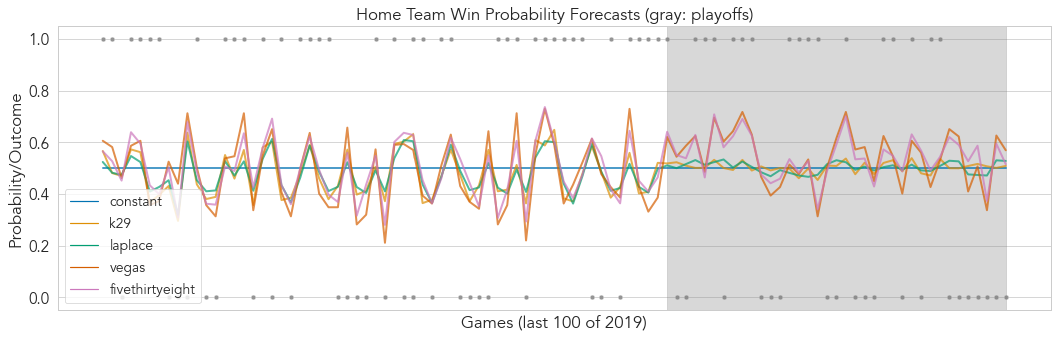

In [11]:
cc.plot_mlb_forecasts(
    data,
    team,
    [2019],
    forecasters[::-1],
    no_playoffs=False,
    window=("2019-10-01", "2019-10-30"),  # playoffs
    n_games=100,
    save_filename=os.path.join(plots_dir, f"forecasts.pdf"),
)

## Main Comparisons

In [12]:
for name_p, name_q in itertools.combinations(forecasters, 2):
    results_pq = cc.compare_forecasts(
            data,
            name_p,
            name_q,
            scoring_rule=scoring_rule,
            alpha=ALPHA,
            v_opt=V_OPT,
            compute_e=True,
        )
    lcb, ucb, e_pq, e_qp = [results_pq[key].tail(1).item() 
                            for key in ["lcb", "ucb", "e_pq", "e_qp"]]
    print(f"{name_p:15} vs. {name_q:8}: ({lcb:8.5f}, {ucb:8.5f}),\t e_pq {e_pq:8.2f}, e_qp {e_qp:8.2f}")

fivethirtyeight vs. vegas   : (-0.00265, -0.00061),	 e_pq     0.09, e_qp  2979.04


/Users/yjchoe/Dropbox/Code/ComparingForecasters/comparecast/eprocess.py:48: RuntimeWarning: divide by zero encountered in log
  + np.log(gammainc(v_rho_csq, np.maximum(1e-8, cs_v_rho_csq)))


fivethirtyeight vs. laplace : ( 0.00456,  0.00794),	 e_pq 10000000.00, e_qp     0.03


/Users/yjchoe/Dropbox/Code/ComparingForecasters/comparecast/eprocess.py:48: RuntimeWarning: divide by zero encountered in log
  + np.log(gammainc(v_rho_csq, np.maximum(1e-8, cs_v_rho_csq)))


fivethirtyeight vs. k29     : ( 0.00761,  0.01209),	 e_pq 10000000.00, e_qp     0.02


/Users/yjchoe/Dropbox/Code/ComparingForecasters/comparecast/eprocess.py:48: RuntimeWarning: divide by zero encountered in log
  + np.log(gammainc(v_rho_csq, np.maximum(1e-8, cs_v_rho_csq)))


fivethirtyeight vs. constant: ( 0.00565,  0.00936),	 e_pq 10000000.00, e_qp     0.03


/Users/yjchoe/Dropbox/Code/ComparingForecasters/comparecast/eprocess.py:48: RuntimeWarning: divide by zero encountered in log
  + np.log(gammainc(v_rho_csq, np.maximum(1e-8, cs_v_rho_csq)))


vegas           vs. laplace : ( 0.00596,  0.00980),	 e_pq 10000000.00, e_qp     0.02


/Users/yjchoe/Dropbox/Code/ComparingForecasters/comparecast/eprocess.py:48: RuntimeWarning: divide by zero encountered in log
  + np.log(gammainc(v_rho_csq, np.maximum(1e-8, cs_v_rho_csq)))


vegas           vs. k29     : ( 0.00905,  0.01392),	 e_pq 10000000.00, e_qp     0.02


/Users/yjchoe/Dropbox/Code/ComparingForecasters/comparecast/eprocess.py:48: RuntimeWarning: divide by zero encountered in log
  + np.log(gammainc(v_rho_csq, np.maximum(1e-8, cs_v_rho_csq)))


vegas           vs. constant: ( 0.00713,  0.01115),	 e_pq 10000000.00, e_qp     0.02


/Users/yjchoe/Dropbox/Code/ComparingForecasters/comparecast/eprocess.py:48: RuntimeWarning: divide by zero encountered in log
  + np.log(gammainc(v_rho_csq, np.maximum(1e-8, cs_v_rho_csq)))


laplace         vs. k29     : ( 0.00197,  0.00524),	 e_pq 5384731.42, e_qp     0.03
laplace         vs. constant: (-0.00044,  0.00295),	 e_pq     6.37, e_qp     0.07
k29             vs. constant: (-0.00464, -0.00005),	 e_pq     0.04, e_qp    48.88


## Sample Pair Comparison

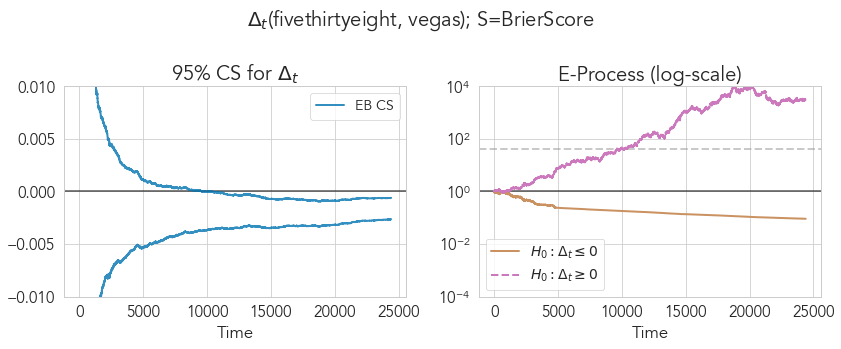

In [13]:
scoring_rule = "brier"

results, axes = cc.plot_comparison(
    data, 
    "fivethirtyeight",
    "vegas",
    scoring_rule=scoring_rule,
    alpha=ALPHA,
    v_opt=V_OPT,
    plots_dir=plots_dir,
    baselines=(),
    use_logx=False,
    ylim_scale=0.01,
    font_scale=1.75,
    plot_width=False,
)

In [14]:
# final-game values
results.tail(1)

,time,lcb,ucb,e_pq,e_qp
25164,25165,-0.002652,-0.000615,0.09131,2979.039872


### All Pairwise Comparisons

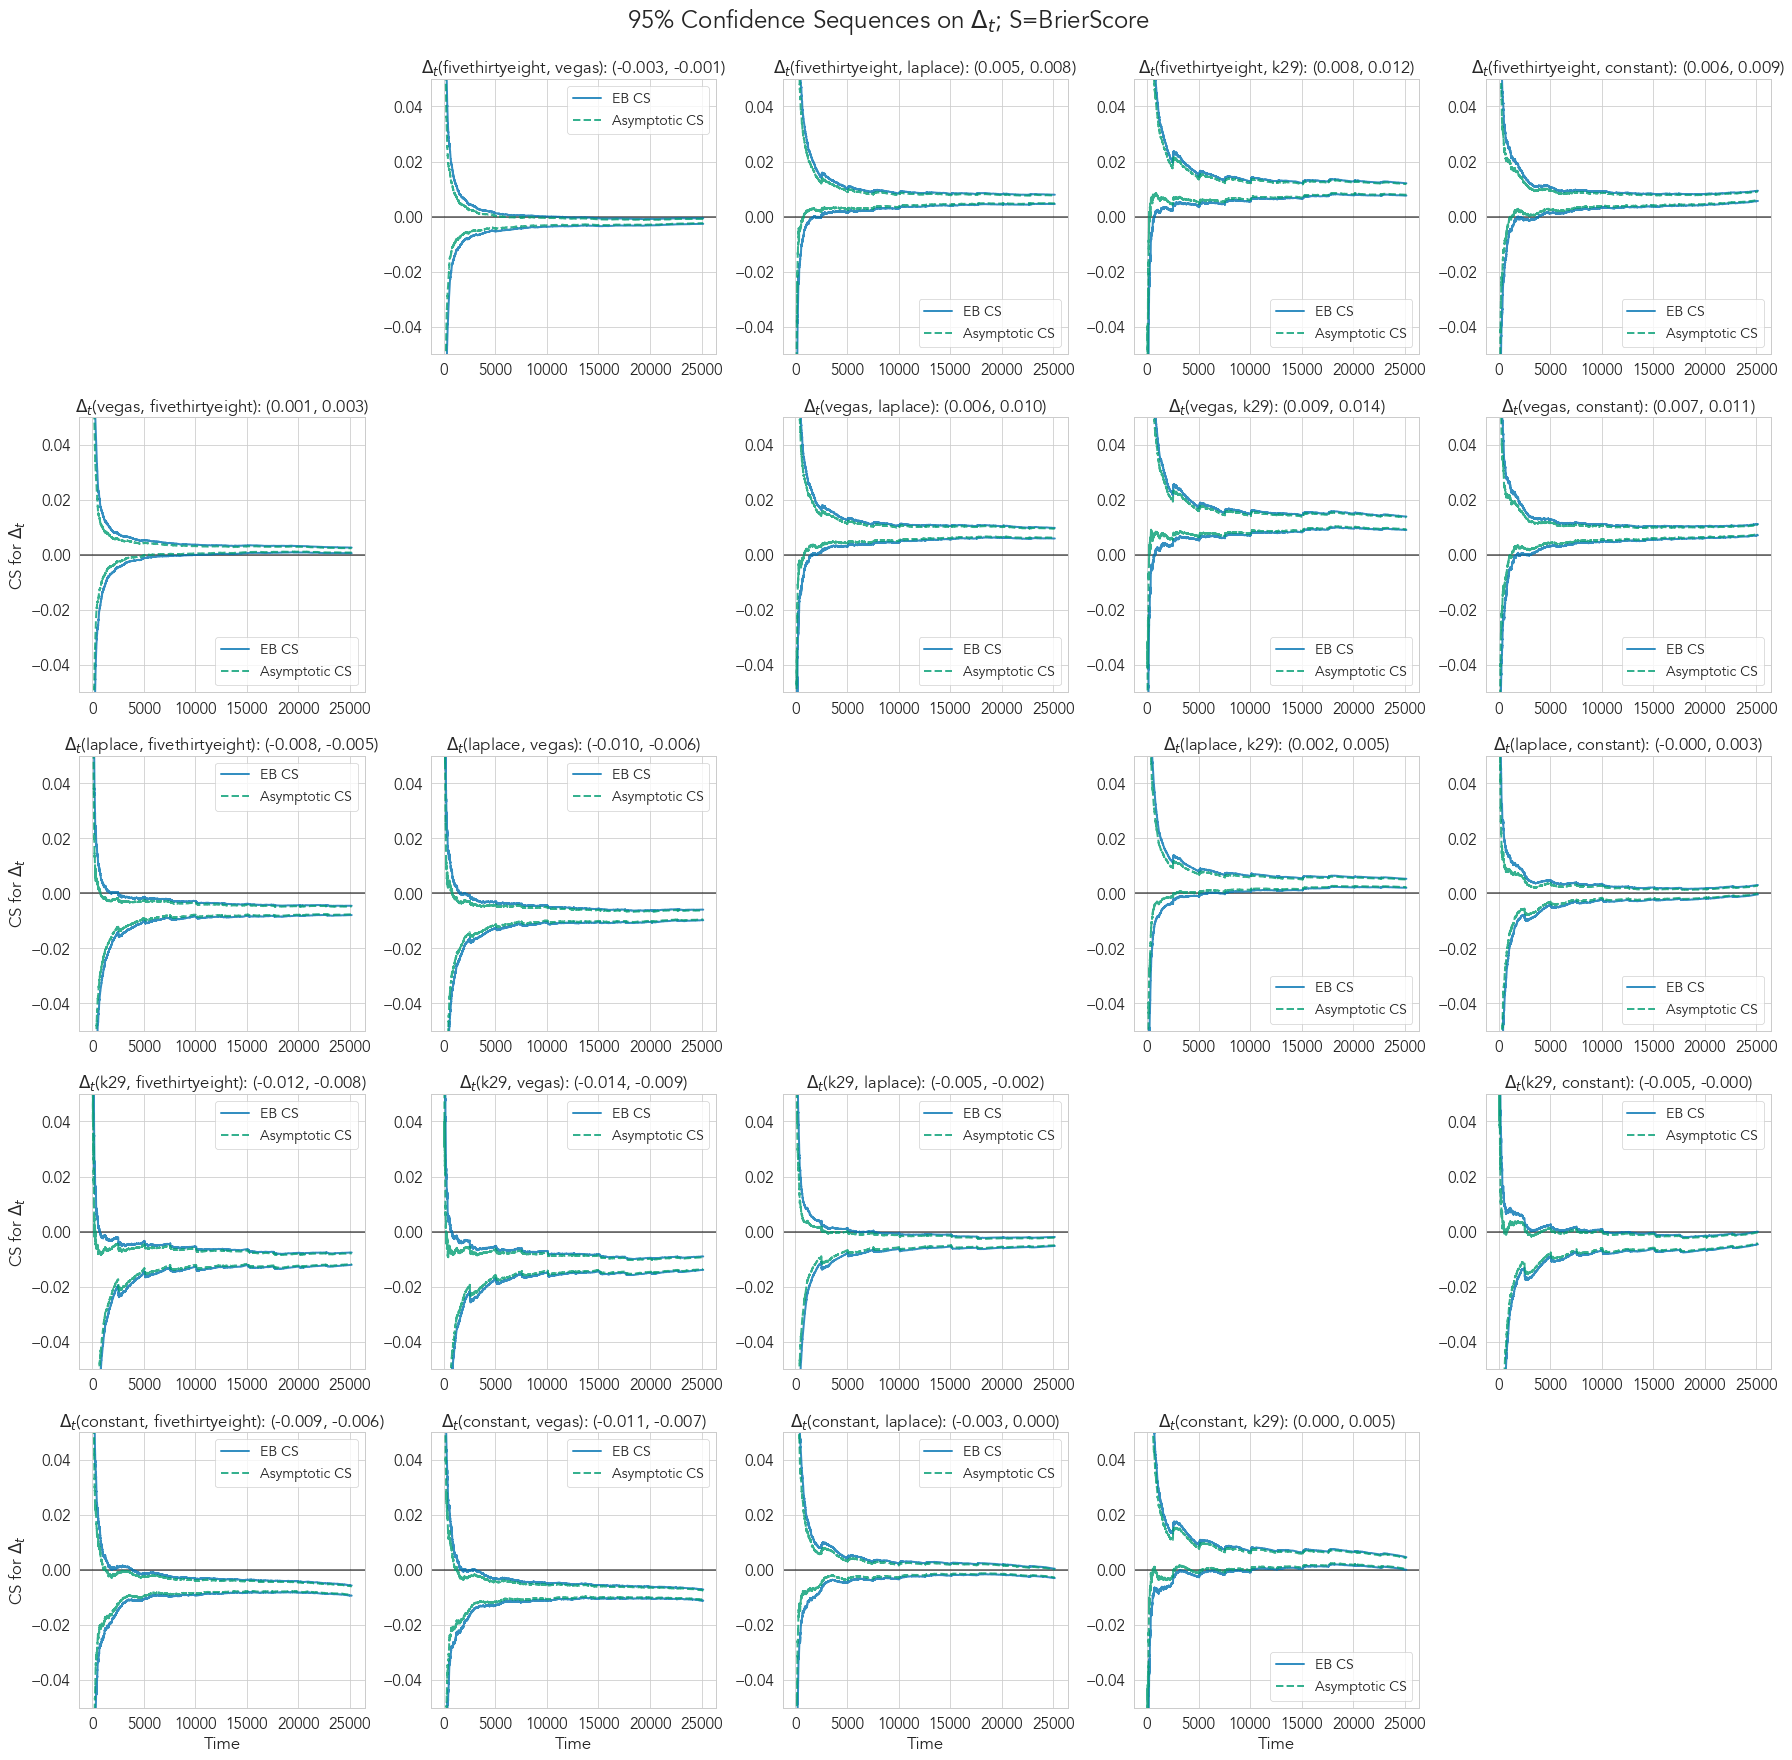

In [15]:
ax = cc.plot_pairwise_comparisons(
    data, 
    forecasters, 
    scoring_rule="brier",
    alpha=ALPHA,
    v_opt=V_OPT,
    plots_dir=plots_dir,
    baselines=("acs"),
    use_logx=False,
    ylim_scale=0.05,
    font_scale=1.75,
)

### Comparison Against Laplace, i.e., the Rolling Season Average

In [16]:
def compare_against_baseline(data, forecasters, baseline, scoring_rule, save_csv=True, **kwargs):
    compdata = data[["date", "time", "y"] + forecasters].copy()
    for forecaster in forecasters:
        if forecaster == baseline:
            continue
        results = cc.compare_forecasts(
            data, 
            forecaster, 
            baseline, 
            scoring_rule=scoring_rule,
            **kwargs
        )
        compdata[f"{forecaster}_lcb"] = results["lcb"].values
        compdata[f"{forecaster}_ucb"] = results["ucb"].values
        compdata[f"{forecaster}_epq"] = results["e_pq"].values
        compdata[f"{forecaster}_eqp"] = results["e_qp"].values
    if save_csv:
        compdata.to_csv(
            os.path.join(plots_dir, f"{scoring_rule}_against_{baseline}.csv")
        )
    return compdata

In [17]:
compdata = compare_against_baseline(
    data, 
    forecasters, 
    baseline="laplace", 
    scoring_rule=scoring_rule,
    alpha=ALPHA,
    v_opt=V_OPT,
)
compdata.tail(7)

/Users/yjchoe/Dropbox/Code/ComparingForecasters/comparecast/eprocess.py:48: RuntimeWarning: divide by zero encountered in log
  + np.log(gammainc(v_rho_csq, np.maximum(1e-8, cs_v_rho_csq)))
/Users/yjchoe/Dropbox/Code/ComparingForecasters/comparecast/eprocess.py:48: RuntimeWarning: divide by zero encountered in log
  + np.log(gammainc(v_rho_csq, np.maximum(1e-8, cs_v_rho_csq)))
/Users/yjchoe/Dropbox/Code/ComparingForecasters/comparecast/eprocess.py:48: RuntimeWarning: divide by zero encountered in log
  + np.log(gammainc(v_rho_csq, np.maximum(1e-8, cs_v_rho_csq)))


,date,time,y,fivethirtyeight,vegas,laplace,k29,constant,fivethirtyeight_lcb,fivethirtyeight_ucb,...,vegas_epq,vegas_eqp,k29_lcb,k29_ucb,k29_epq,k29_eqp,constant_lcb,constant_ucb,constant_epq,constant_eqp
25158,2019-10-22,24384,0,0.620572,0.651163,0.528860,0.500000,0.5,0.004573,0.007947,...,10000000.0,0.024546,-0.005235,-0.001965,0.034049,5.339657e+06,-0.002954,0.000443,0.070680,6.384300
25159,2019-10-23,24385,0,0.590066,0.622704,0.526425,0.499644,0.5,0.004570,0.007944,...,10000000.0,0.024545,-0.005234,-0.001964,0.034048,5.298197e+06,-0.002953,0.000445,0.070731,6.358593
25160,2019-10-25,24386,0,0.526852,0.409836,0.475988,0.508571,0.5,0.004568,0.007942,...,10000000.0,0.024544,-0.005235,-0.001965,0.034048,5.345911e+06,-0.002954,0.000444,0.070687,6.380670
25161,2019-10-26,24387,0,0.586974,0.506972,0.473813,0.516476,0.5,0.004563,0.007937,...,10000000.0,0.024544,-0.005236,-0.001967,0.034048,5.409253e+06,-0.002955,0.000443,0.070639,6.404785
25162,2019-10-27,24388,0,0.373102,0.337323,0.471658,0.507236,0.5,0.004566,0.007940,...,10000000.0,0.024543,-0.005238,-0.001968,0.034048,5.462140e+06,-0.002956,0.000441,0.070588,6.430937
25163,2019-10-29,24389,0,0.594638,0.626462,0.530477,0.501092,0.5,0.004563,0.007936,...,10000000.0,0.024541,-0.005236,-0.001967,0.034047,5.415325e+06,-0.002955,0.000443,0.070646,6.400921
25164,2019-10-30,24390,0,0.515172,0.569340,0.528089,0.508798,0.5,0.004563,0.007937,...,10000000.0,0.024541,-0.005235,-0.001966,0.034047,5.384731e+06,-0.002953,0.000444,0.070700,6.373469


$\LaTeX$

In [18]:
# Brier against laplace (Table 4a)
scoring_rule = "brier"
baseline = "vegas"

compdata = compare_against_baseline(
    data, 
    forecasters, 
    baseline=baseline, 
    scoring_rule=scoring_rule,
    save_csv=False,
    alpha=ALPHA,
    v_opt=V_OPT,
)

for forecaster in forecasters:
    if forecaster != baseline:
        lcb = compdata[forecaster + "_lcb"].tail(1).item()
        ucb = compdata[forecaster + "_ucb"].tail(1).item()
        e_pq = compdata[forecaster + "_epq"].tail(1).item()
        e_qp = compdata[forecaster + "_eqp"].tail(1).item()
        print("\\texttt{{{:15s}}} & ({:8.5f}, {:8.5f}) & {:8.2f} \\\\".format(
            forecaster, lcb, ucb, e_qp
        ))

/Users/yjchoe/Dropbox/Code/ComparingForecasters/comparecast/eprocess.py:48: RuntimeWarning: divide by zero encountered in log
  + np.log(gammainc(v_rho_csq, np.maximum(1e-8, cs_v_rho_csq)))
/Users/yjchoe/Dropbox/Code/ComparingForecasters/comparecast/eprocess.py:48: RuntimeWarning: divide by zero encountered in log
  + np.log(gammainc(v_rho_csq, np.maximum(1e-8, cs_v_rho_csq)))


\texttt{fivethirtyeight} & (-0.00265, -0.00061) &  2979.04 \\
\texttt{laplace        } & (-0.00980, -0.00596) & 10000000.00 \\
\texttt{k29            } & (-0.01392, -0.00905) & 10000000.00 \\
\texttt{constant       } & (-0.01115, -0.00713) & 10000000.00 \\


/Users/yjchoe/Dropbox/Code/ComparingForecasters/comparecast/eprocess.py:48: RuntimeWarning: divide by zero encountered in log
  + np.log(gammainc(v_rho_csq, np.maximum(1e-8, cs_v_rho_csq)))


In [19]:
# Winkler against baseline (Table 4b)
scoring_rule = "winkler"
baseline = "vegas"

compdata = compare_against_baseline(
    data, 
    forecasters, 
    baseline=baseline, 
    scoring_rule=scoring_rule,
    save_csv=False,
    alpha=ALPHA,
    v_opt=V_OPT,
    ucb_only=True,
    c=2,
)

for forecaster in forecasters:
    if forecaster != baseline:
        lcb = compdata[forecaster + "_lcb"].tail(1).item()
        ucb = compdata[forecaster + "_ucb"].tail(1).item()
        e_pq = compdata[forecaster + "_epq"].tail(1).item()
        e_qp = compdata[forecaster + "_eqp"].tail(1).item()
        print("\\texttt{{{:15s}}} & ({:8.5f}, {:8.5f}) & {:8.2f} \\\\".format(
            forecaster, lcb, ucb, e_qp
        ))

\texttt{fivethirtyeight} & (    -inf, -0.01012) & 15443.10 \\
\texttt{laplace        } & (    -inf, -0.04723) & 10000000.00 \\
\texttt{k29            } & (    -inf, -0.14684) & 10000000.00 \\
\texttt{constant       } & (    -inf, -0.05165) & 10000000.00 \\


In [20]:
# WSN forecasts for WS (Table 1)
for forecaster in forecasters:
    print(f"{forecaster:15s}", " & ".join(
        [(f"{100*p:.1f}\%" if i in [2, 3, 4] else f"{100*(1-p):.1f}\%")
         for i, p in enumerate(compdata[forecaster].tail(7).values)]
    ))

fivethirtyeight 37.9\% & 41.0\% & 52.7\% & 58.7\% & 37.3\% & 40.5\% & 48.5\%
vegas           34.9\% & 37.7\% & 41.0\% & 50.7\% & 33.7\% & 37.4\% & 43.1\%
laplace         47.1\% & 47.4\% & 47.6\% & 47.4\% & 47.2\% & 47.0\% & 47.2\%
k29             50.0\% & 50.0\% & 50.9\% & 51.6\% & 50.7\% & 49.9\% & 49.1\%
constant        50.0\% & 50.0\% & 50.0\% & 50.0\% & 50.0\% & 50.0\% & 50.0\%
